In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aparnasharma10010","key":"131c0e5c58cfde1b39da36dd8ad9b47d"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Loading the X-ray Image Dataset**

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force # again dowloading the dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:16<00:00, 40.1MB/s]
100% 2.29G/2.29G [00:16<00:00, 153MB/s] 


# **Unzip the Dataset**

In [4]:
# Delete the existing extracted folder (to start fresh):
!rm -rf chest_xray_pneumonia

In [5]:
# Re-unzip with skip-on-existing to avoid interuption:
!unzip -n chest-xray-pneumonia.zip -d chest_xray_pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray_pneumonia/chest_xray/train/NORMAL/IM-0442-

# **Load the Necessary Libraries**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from  tensorflow.keras import models , layers , Sequential , callbacks
from tensorflow.keras.metrics import Precision, Recall, AUC


# **Load with Keras**

In [7]:
# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/chest_xray_pneumonia/chest_xray/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

# Validation Dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/chest_xray_pneumonia/chest_xray/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

# Testing Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/chest_xray_pneumonia/chest_xray/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


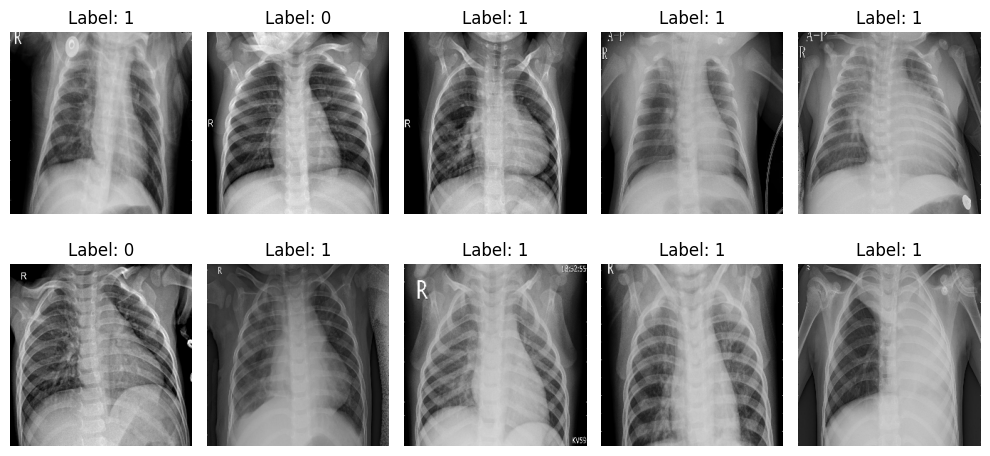

In [8]:
# Take one batch of 10 images
for images, labels in train_ds.unbatch().batch(10).take(1):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)  # RGB image
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.tight_layout()

# **Data Preprocessing**

In [9]:
# Normalize ( as neural networks work best when scaled and also converges faster)
def normalize(image , label):
  image = tf.cast(image , tf.float32) / 255.0
  return image , label

# passing all data(train,test,val) to maintain consistency
train_ds = train_ds.map(normalize)
validation_ds = train_ds.map(normalize)
test_ds = train_ds.map(normalize)

In [10]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

# **Model Building**

In [11]:
def build_model():
  model = models.Sequential([
      data_augmentation,

      # 1st Convolution Block
      layers.Conv2D(128,(3,3) , padding = 'same' , activation = 'relu' , input_shape = (256,256,3)),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2), strides = (2,2) , padding = 'valid'),


      # 2nd Convolution Block
      layers.Conv2D(64,(3,3) , padding = 'same' , activation = 'relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2), strides = (2,2) , padding = 'valid'),

      # 3rd Convolution Block
      layers.Conv2D(64,(3,3) , padding = 'same' , activation = 'relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2,2), strides = (2,2) , padding = 'valid'),

      # Flatten
      layers.Flatten(),

      # Dense Layers
      layers.Dense(128 , activation = 'relu'),
      layers.Dropout(0.4),
      layers.Dense(32,activation = 'relu'),
      layers.Dropout(0.4),
      layers.Dense(1, activation = 'sigmoid')
   ])
  return model


In [12]:
# Caling the function
model = build_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Model compile
model.compile(optimizer ='SGD',
              loss = 'binary_crossentropy',
              metrics = ['accuracy',Precision(), Recall(), AUC()]
             )

In [14]:
# Set Callbacks
early_stopping = callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(factor=0.2, patience=3)

# **Model Training**

In [15]:
history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = 20,
    batch_size = 32,
    callbacks = [early_stopping,reduce_lr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 521ms/step - accuracy: 0.7362 - auc: 0.7150 - loss: 0.8693 - precision: 0.8076 - recall: 0.8435 - val_accuracy: 0.7429 - val_auc: 0.5000 - val_loss: 5.0083 - val_precision: 0.7429 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 590ms/step - accuracy: 0.8727 - auc: 0.9363 - loss: 0.2819 - precision: 0.9069 - recall: 0.9230 - val_accuracy: 0.7429 - val_auc: 0.5000 - val_loss: 3.5709 - val_precision: 0.7429 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 533ms/step - accuracy: 0.9201 - auc: 0.9607 - loss: 0.2173 - precision: 0.9362 - recall: 0.9576 - val_accuracy: 0.7429 - val_auc: 0.5000 - val_loss: 1.4419 - val_precision: 0.7429 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 531ms/step - accuracy: 0.9227 - auc: 0.9698 - loss: 0.1935 - precision: 0.9435 - recall: 0.9527 - val_accuracy: 0.7429 - val_auc: 0.5156 - val_loss: 

# Interpretation :
Training stopped early because our model wasn’t improving, which saves time and avoids overfitting.

# **Model Evaluation**

In [16]:
test_results = model.evaluate(test_ds)
print(dict(zip(model.metrics_names , test_results)))

163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 194ms/step - accuracy: 0.7420 - auc: 0.5246 - loss: 0.5764 - precision: 0.7420 - recall: 1.0000
{'loss': 0.5753524303436279, 'compile_metrics': 0.7429064512252808}


# **Visualizing the Results**

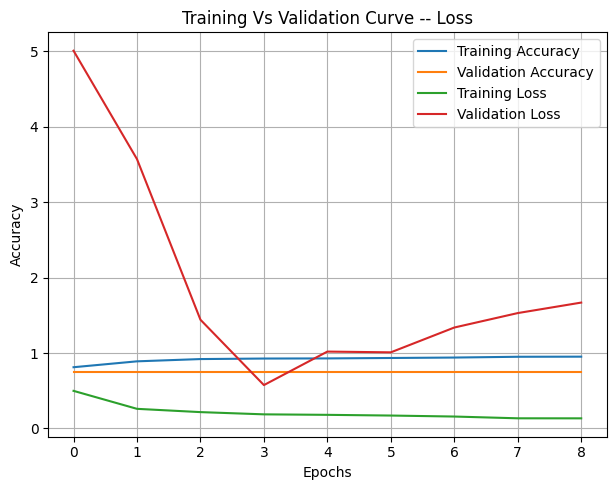

In [17]:
# Sizing the Canvas
plt.figure(figsize=(12,5))

# Plot Training and Validation Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label = ['Training Accuracy'])
plt.plot(history.history['val_accuracy'], label = ['Validation Accuracy'])
plt.title('Training Vs Validation Curve -- Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training and Validation Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label = ['Training Loss'])
plt.plot(history.history['val_loss'], label = ['Validation Loss'])
plt.title('Training Vs Validation Curve -- Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()